### Intro

In this notebook you can play with a combinatorial optimization problem we solve with CappedIGW. This example is not described in the original paper, but shows the potential for CappedIGW for in-context learning with LLM models.  Our particular task is defined in [LetCatEnvironment](https://github.com/mrucker/onoff_experiments/blob/main/demo/LetCatEnvironment.py), and we select 3 examples for the prompt from a collection of 30,000 examples.

In the notebook below we define a reference policy and a loss predictor for this dataset. To use CappedIGW this is all you have to define. The rest of the algorithm can be treated as a black box.

For the reference policy below we use embeddings from a transformer to calculate similarity scores. We then sample from a softmax distribution of the similarity ranking using a Gumbel distribution.

A quick note, throughout the notebook we use [Coba](https://github.com/VowpalWabbit/coba) to orchestrate our experiments and record their results. It is not necessary to learn about or use coba to understand and utilize CappedIGW beyond this notebook.

Hat tip to Francesco Orabona for his [pytorch coin betting optimizer](https://github.com/bremen79/parameterfree).

# Install Dependencies

In [1]:
import sys
MIN_PYTHON = (3, 10)
assert sys.version_info >= MIN_PYTHON, f"requires Python {'.'.join([str(n) for n in MIN_PYTHON])} or newer"

%pip install torch coba scipy numpy matplotlib cloudpickle sentence-transformers ipywidgets parameterfree peft mock --quiet --quiet

Note: you may need to restart the kernel to use updated packages.


# Set Device As Desired

In [1]:
import torch

#device='cpu'
device='cuda'

torch.set_default_device(device)
if device == 'cpu':
    import os
    os.environ["CUDA_VISIBLE_DEVICES"]=""

# Actually Run Demo

Precompute Embeddings and Preload Environment (with llm)

In [2]:
from LetCatEnvironment import LetCatEnvironment
from Embedding import embedder
import json
import time

start = time.time()
print('embedding examples ...', end='', flush=True)
with open('LetCatTrain.jsonl',mode='rb') as f:
    examples = [ json.loads(line) for line in f ]
ex_embeddings = embedder(examples)
end = time.time()
print(f' elapsed time {end-start} seconds')

start = time.time()
print('making environment ...', end='', flush=True)
letcat = LetCatEnvironment()
end = time.time()
print(f' elapsed time {end-start} seconds')

embedding examples ... elapsed time 7.350554466247559 seconds
making environment ... elapsed time 0.36066198348999023 seconds


## Run Baselines

The baseline strategies are:
* **ZeroShot**: at 0.75 loss (75% error rate), this is no better than random.
* **SimilaritySelector**: approximately 40% error rate.  This is a popular technique which selects examples whose embedding has maximal cosine with the problem embedding.
* **Randomized SimilaritySelector**: approximately 45% error rate.  Our reference policy needs to broadly sample from the action space, so we randomize SimilaritySelector by adding Gumbel distributed noise.
* **Hand tuned strategy**: approximately 25% error rate.  We exploit our knowledge of the task to design a custom similarity selector with good performance.

Note we pay a price by randomizing SimilaritySelector to construct our reference policy.  In exchange, we hope to learn to match the hand tuned strategy.

2023-09-03 04:55:48 -- Experiment Started
2023-09-03 04:55:48 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Recording Learner 1 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Recording Learner 2 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Recording Learner 3 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Peeking at Environment 0... (0.08 seconds) (completed)
2023-09-03 04:55:48 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-09-03 04:55:48 -- Peeking at Environment 0... (0.07 seconds) (completed)
2023-09-03 04:56:34 -- Evaluating Learner 0 on Environment 0... (46.58 seconds) (completed)
2023-09-03 04:56:34 -- Peeking at Environment 0... (0.07 seconds) (completed)
2023-09-03 04:57:21 -- Evaluating Learner 1 on Environment 0... (46.61 seconds) (completed)
2023-09-03 04:57:21 -- Peeking at En

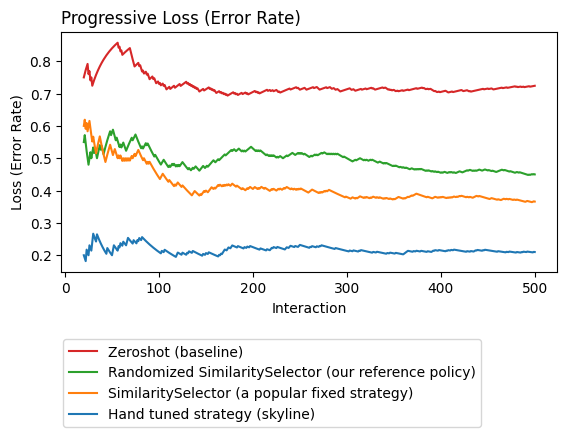

In [5]:
from Strategies import RandomizedSimilarity, FewShotFixedStrategy, ZeroShotStrategy
import coba

batch_size = 4
n_batches = 125

def taskid(item):
    text = item if isinstance(item,str) else item['instruction']
    return 'first' if 'first' in text else 'second' if 'second' in text else 'last'

rs_00_1_strat = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3, stratum=taskid)
rs_00_1       = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.00, set_size=3)
rs_015_1      = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=1 , temperature=.015, set_size=3)

env = coba.Environments(letcat).take(n_batches*batch_size).batch(batch_size)
lrn = [
    FewShotFixedStrategy(rs_00_1_strat), # skyline
    FewShotFixedStrategy(rs_00_1),       # greedy reference policy (difference from reference policy is overhead of exploration)
    FewShotFixedStrategy(rs_015_1),      # our reference policy
    ZeroShotStrategy(),                  # baseline
]

result = coba.Experiment(env,lrn).run(processes=1)
result.plot_learners(xlim=(20,None),
                     title='Progressive Loss (Error Rate)',
                     ylabel='Loss (Error Rate)',
                     labels=['Hand tuned strategy (skyline)',
                             'SimilaritySelector (a popular fixed strategy)', 
                             'Randomized SimilaritySelector (our reference policy)', 
                             'Zeroshot (baseline)',
                            ])

## Run CappedIGW

CappedIGW starts out no better than the reference policy, but as hoped, CappedIGW performance approaches that of the skyline strategy.

2023-09-03 12:15:15 -- Experiment Started
2023-09-03 12:15:15 -- Recording Learner 0 parameters... (0.0 seconds) (completed)
2023-09-03 12:15:15 -- Recording Evaluator 0 parameters... (0.0 seconds) (completed)
2023-09-03 12:15:15 -- Peeking at Environment 0... (0.08 seconds) (completed)
2023-09-03 12:15:15 -- Recording Environment 0 parameters... (0.0 seconds) (completed)
2023-09-03 12:15:15 -- Peeking at Environment 0... (0.07 seconds) (completed)
2023-09-03 15:05:11 -- Evaluating Learner 0 on Environment 0... (10195.77 seconds) (completed)
2023-09-03 15:05:11 -- Experiment Finished


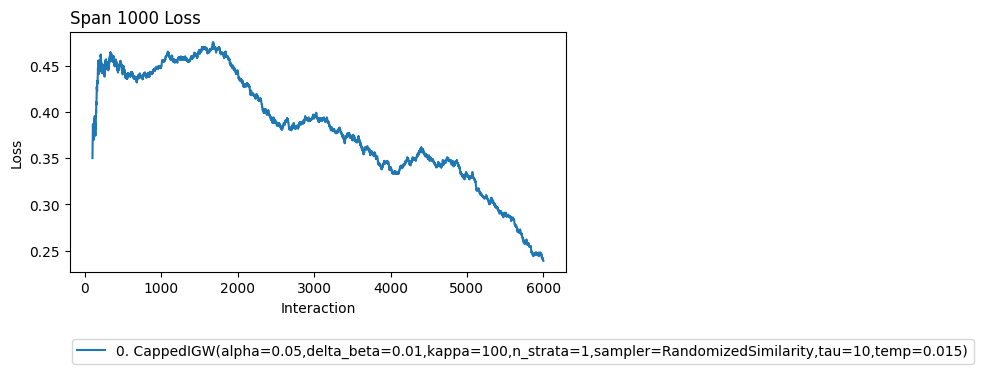

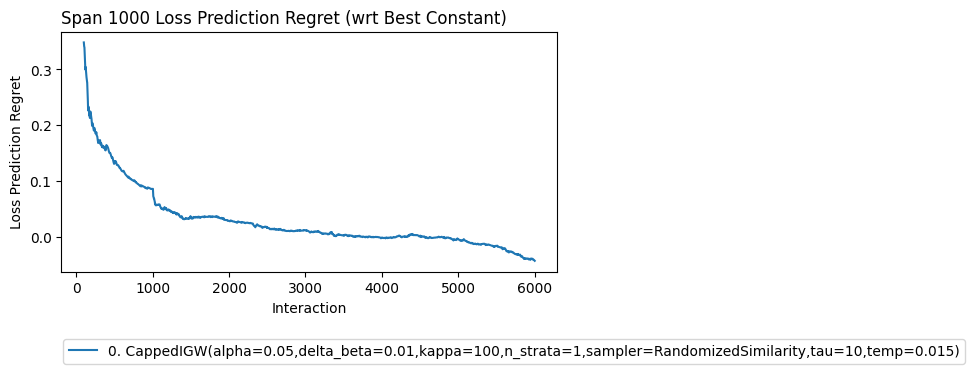

In [7]:
import coba
import numpy
import parameterfree
from CappedIGW import CappedIGW
from LetCatEnvironment import LetCatEnvironment
from LossPredictors import LetCatLossPredictor
from Strategies import RandomizedSimilarity

gamma_tzero = 1e-6
batch_size = 4
n_batches = 1_500

torch.manual_seed(2112)
numpy.random.seed(45)

rs_015_30 = RandomizedSimilarity(embedder, examples, ex_embeddings, batch_size=30, temperature=.015, set_size=3)

fhat = LetCatLossPredictor(device)

env = coba.Environments(letcat).take(n_batches*batch_size).batch(batch_size)
lrn = [
    CappedIGW(mu=rs_015_30, fhat=fhat, gamma_sched=lambda t: (1 + t/gamma_tzero)**(0.5))
]

result = coba.Experiment(env,lrn).run(processes=1)
result.plot_learners(xlim=(100,None), span=1_000, title='Span 1000 Loss', ylabel='Loss')
result.where(learner_id=len(lrn)-1).plot_learners(y='loss_prediction_regret',xlim=(100,None), span=1_000, title="Span 1000 Loss Prediction Regret (wrt Best Constant)", ylabel="Loss Prediction Regret")